In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Exercise

## solution a)

Sample Data

In [2]:
publicity = np.array([1.5, 2.0, 2.3, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])

sales = np.array([5.2, 6.8, 7.5, 8.0, 9.0, 10.2, 11.5, 12.0, 13.5, 14.0, 15.0, 15.5, 16.2, 17.0, 18.0, 18.5, 19.5, 20.0, 21.0, 22.0])

visualizing the data

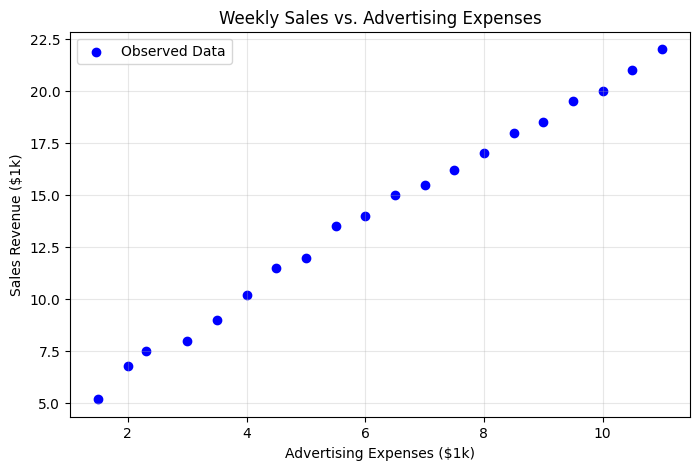

In [3]:
plt.figure(figsize=(8, 5))
plt.scatter(publicity, sales, c='blue', label='Observed Data')
plt.xlabel("Advertising Expenses ($1k)")
plt.ylabel("Sales Revenue ($1k)")
plt.title("Weekly Sales vs. Advertising Expenses")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Our model is defined as follows:


In [15]:
with pm.Model() as model:
    #Data Containers
    x_data = pm.Data("x_data", publicity)
    y_data = pm.Data("y_data", sales)

    #Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear relation
    mu = alpha + beta * x_data

    #Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_data)

    #sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


Estimating the coefficients and Show the HDI

In [10]:
summary = az.summary(trace, var_names=["alpha", "beta", "sigma"], hdi_prob=0.94)
print(summary[["mean", "sd", "hdi_3%", "hdi_97%"]])

        mean     sd  hdi_3%  hdi_97%
alpha  3.382  0.222   2.946    3.784
beta   1.705  0.032   1.644    1.767
sigma  0.406  0.076   0.281    0.548


Plotting the posteriori distribution

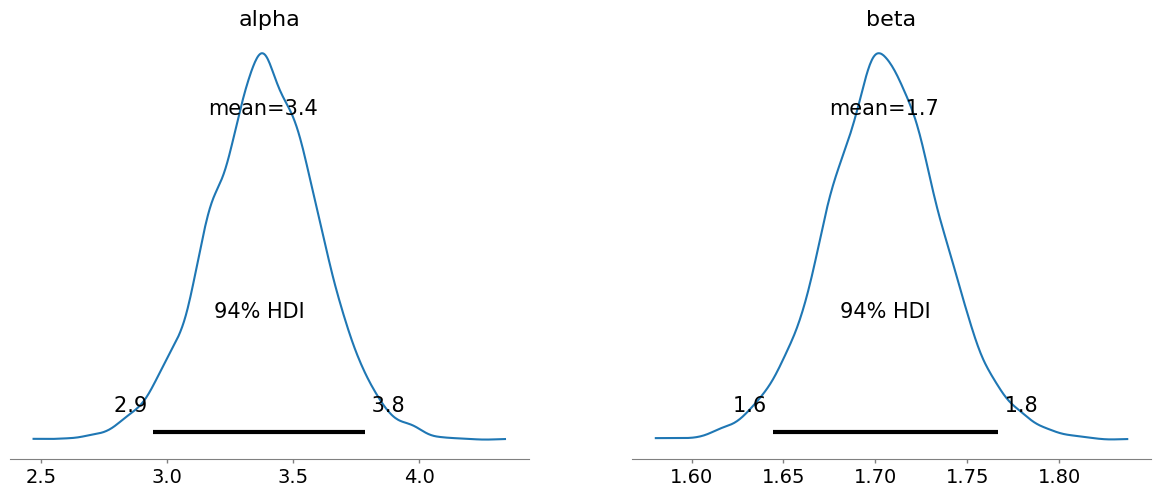

In [11]:
az.plot_posterior(trace, var_names=["alpha", "beta"], hdi_prob=0.94)
plt.show()

Predicting future revenues based off new levels of advertising expenses

In [17]:
x_new = np.linspace(1.0, 13.0, 20)

In [18]:
with model:
    pm.set_data({"x_data": x_new})
    post_pred = pm.sample_posterior_predictive(trace, var_names=["obs"], random_seed=42)

Sampling: [obs]


Output()

Extracting prediction data

In [19]:
predictions = post_pred.posterior_predictive["obs"].stack(sample=("chain", "draw")).values
mean_prediction = predictions.mean(axis=1)
hdi_prediction = az.hdi(predictions.T, hdi_prob=0.94)

/tmp/ipykernel_8266/3844941623.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_prediction = az.hdi(predictions.T, hdi_prob=0.94)


Plotting

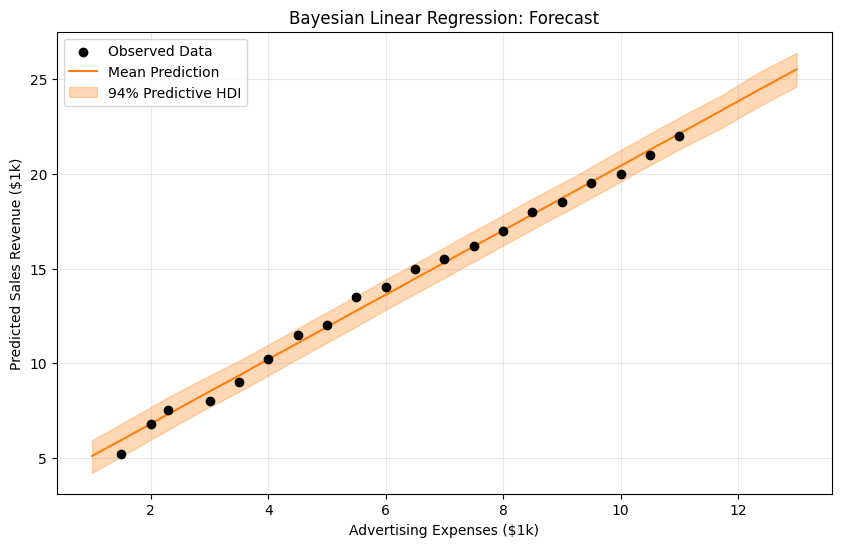

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(publicity, sales, color='black', label='Observed Data', zorder=5)
plt.plot(x_new, mean_prediction, color='C1', label='Mean Prediction')
plt.fill_between(x_new, hdi_prediction[:, 0], hdi_prediction[:, 1],
                 color='C1', alpha=0.3, label='94% Predictive HDI')

plt.title("Bayesian Linear Regression: Forecast")
plt.xlabel("Advertising Expenses ($1k)")
plt.ylabel("Predicted Sales Revenue ($1k)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

An concrette example

In [22]:
hypothetical_x = 12.0

posterior_alpha = trace.posterior["alpha"].values.flatten()
posterior_beta = trace.posterior["beta"].values.flatten()

predicted_mean_sales = posterior_alpha + posterior_beta * hypothetical_x

print(f"Estimated Mean Sales: {predicted_mean_sales.mean():.2f}")
print(f"94% HDI: {az.hdi(predicted_mean_sales, hdi_prob=0.94)}")

Estimated Mean Sales: 23.84
94% HDI: [23.45243552 24.22556459]
